In [11]:
using PyPlot, HiQGA, Random
cd(@__DIR__)

# Geometry

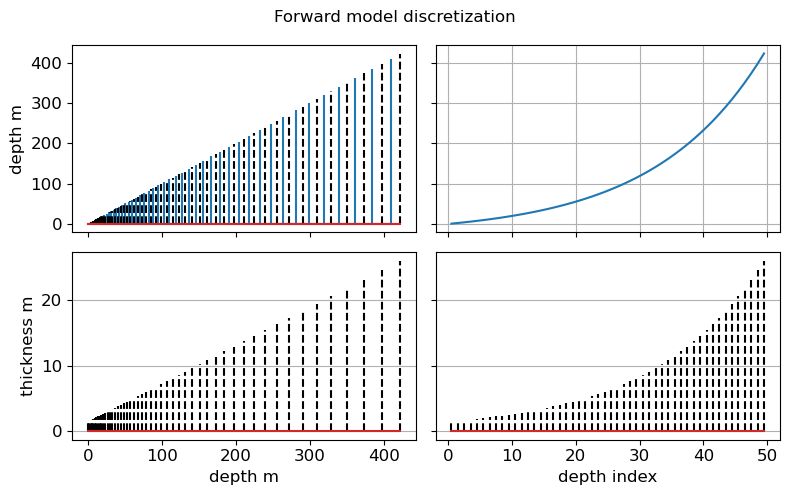

13.0

In [12]:
# model fixed parts, i.e., air
Random.seed!(23)
zfixed   = [-1e5]
ρfixed   = [1e12]
# Model discretization
# Note that the receiver and transmitter need to be in layer 1
zstart = 0.0
extendfrac, dz = 1.06, 1.5
zall, znall, zboundaries = transD_GP.setupz(zstart, extendfrac, dz=dz, n=50, showplot=true)
z, ρ, nfixed = transD_GP.makezρ(zboundaries; zfixed=zfixed, ρfixed=ρfixed);
rRx = 13.

# AEM modeling parameters

In [13]:
# Rx-Tx geometry
zRx = -42.0
zTx = -40.0
include("/scratch/ns59/HiQGA.jl/ASEG_Hobart_Workshop_2024/UDF_data/electronics_halt.jl")
calcjacobian = true # must be on for Occam!
# make SkyTEM operator
aem = transD_GP.SkyTEM1DInversion.dBzdt(;
    timeslow = LM_times, ramplow = LM_ramp, zRxlow=zRx, zTxlow = zTx,
    timeshigh = HM_times, ramphigh = HM_ramp, zRxhigh=zRx, zTxhigh = zTx,
    rRx, rTx, z, ρ, lowpassfcs, calcjacobian);

# Create resistivity model in ohm-m

In [14]:
ρ[(z.>=zstart) .& (z.<50)] .= 20.
ρ[(z.>=50)      .&(z.<80)] .= 1
ρ[(z.>=80)     .&(z.<120)] .= 20
ρ[(z.>=120)    .&(z.<150)] .= 1
ρ[(z.>=150)    .&(z.<250)] .= 50
ρ[(z.>=250)]               .= 150
# add jitter to model in log10 domain
Random.seed!(10)
ρ = 10 .^(0.1*randn(length(ρ)) + log10.(ρ))

51-element Vector{Float64}:
   1.341382983388124e12
  16.544814839634515
  24.779239838115988
  22.61112020246438
  20.506722803537237
  19.044206215637765
  14.62537380424338
  21.47632642722453
  16.843154384000908
  28.355789598476985
  25.729496345687632
  20.87314738232464
  18.73101561106958
   ⋮
  47.67052574218713
  33.487552070558436
  62.52470069992703
  50.363848510776315
 130.48868503812895
 145.05840698011212
 221.1572651991711
 189.85375167595978
 134.87856271911934
 198.70421815564177
 122.48023808196429
 121.54481459591398

# Plot model and data

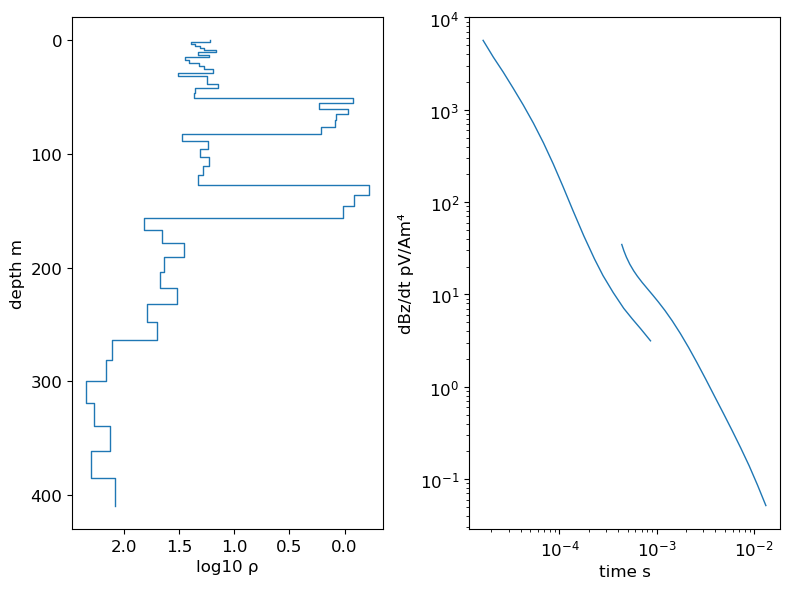

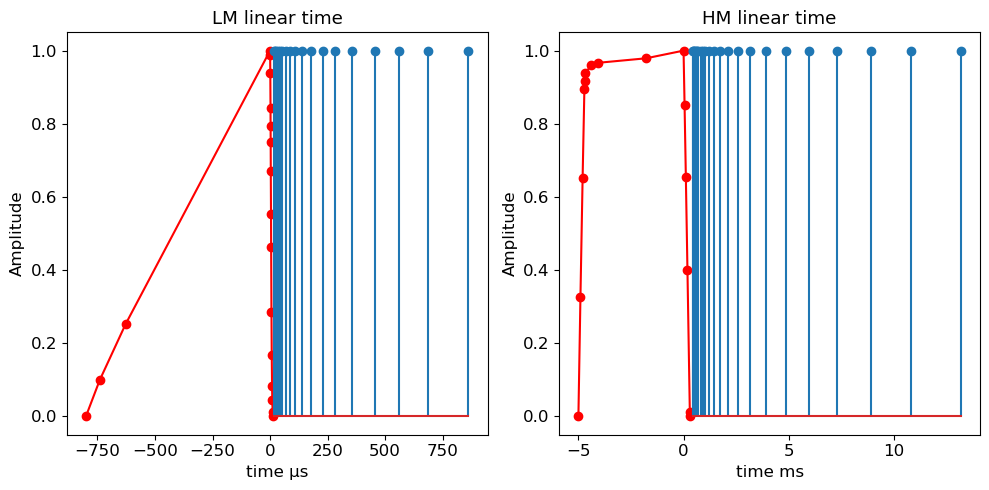

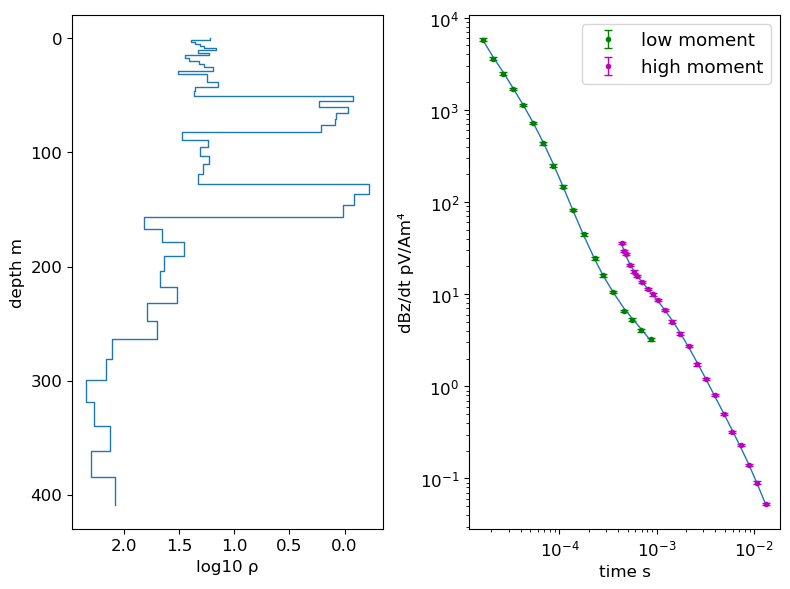

In [15]:
# plot noise free data due to model
transD_GP.plotmodelfield!(aem, log10.(ρ[2:end]))
# add noise to data
transD_GP.SkyTEM1DInversion.makenoisydata!(aem, log10.(ρ[2:end]);
    σ_halt_low=LM_noise, σ_halt_high=HM_noise,
    units = 1e-12)

# do not change until instructed to mess with noise

In [16]:
mess_with_noise = false
fudge_factor = 1/2
mess_with_noise && (aem.W = fudge_factor*aem.W)

false

# Options for gradient descent

In [17]:
# create empty log10 conductivity arrays for start and background
σstart, σ0 = map(x->zeros(length(aem.ρ)-nfixed), 1:2)
# constant value assigned to multiple elements of array (start)
σstart .= -2.
# constant value assigned to multiple elements of array (background)
σ0 .= -2
# :R1 is first difference regularization, :R2 is two succesive first differences
regtype = :R1
# min, max log10 conductivity
lo, hi = -3, 1
# min, max of regularization parameter (Tikhonov parameter)
λ²min, λ²max=-0.5, 7
# how many max tries between λ²min, λ²max
ntries = 10
# When to move on to the next step
knownvalue = 0.7
# what fraction of roughness penalty to use to enforce a penalty in deviations from background## do the inversion
β² = 0.0

0.0

# Do Occam's inversion

In [18]:
m, χ², λ², idx = transD_GP.gradientinv(σstart, σ0, aem; nstepsmax=20,
                            λ²min, λ²max, β², ntries, knownvalue,
                            lo, hi, regtype);

[ Info: iteration: 1 χ²: 15217.040398435975 target: 41
[ Info: iteration: 2 χ²: 9267.488519790344 target: 41
[ Info: iteration: 3 χ²: 2650.874168960383 target: 41
[ Info: iteration: 4 χ²: 595.5359226312354 target: 41
[ Info: iteration: 5 χ²: 170.5892870700975 target: 41
[ Info: iteration: 6 χ²: 113.01632825515985 target: 41
[ Info: iteration: 7 χ²: 51.809724131127446 target: 41
[ Info: iteration: 8 χ²: 45.78559774154544 target: 41
[ Info: iteration: 9 χ²: 40.999999999998565 target: 41


# Plot results

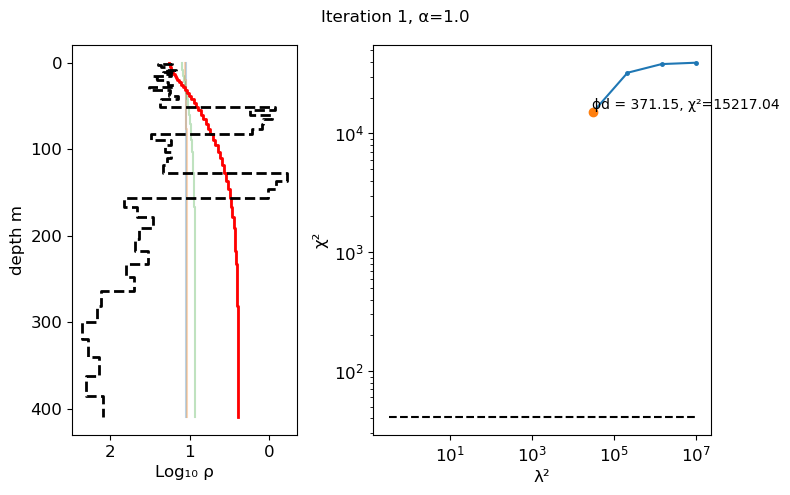

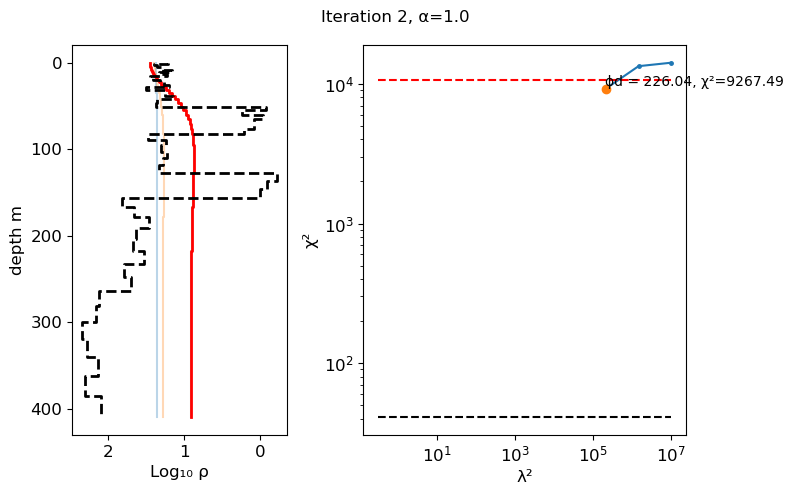

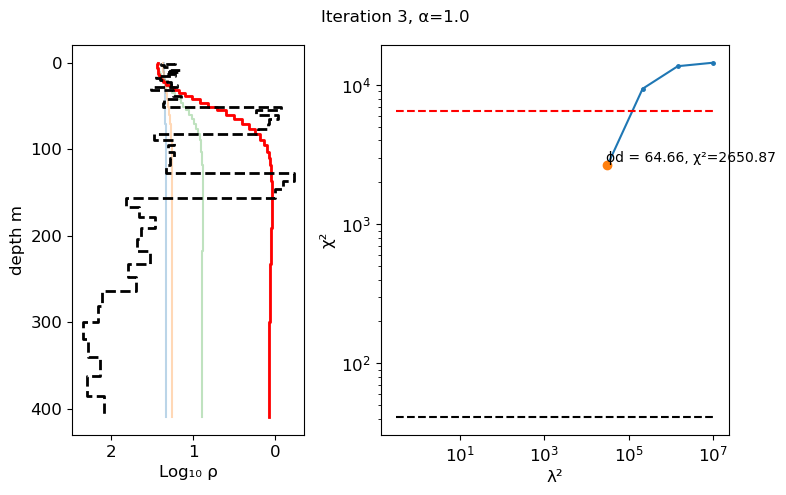

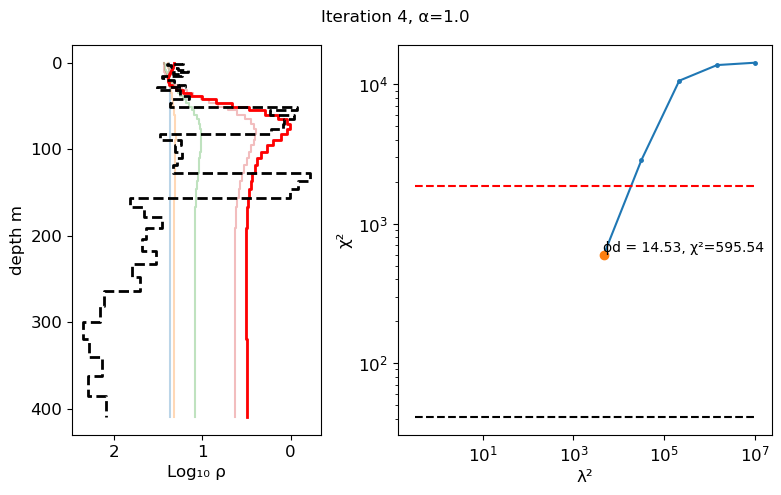

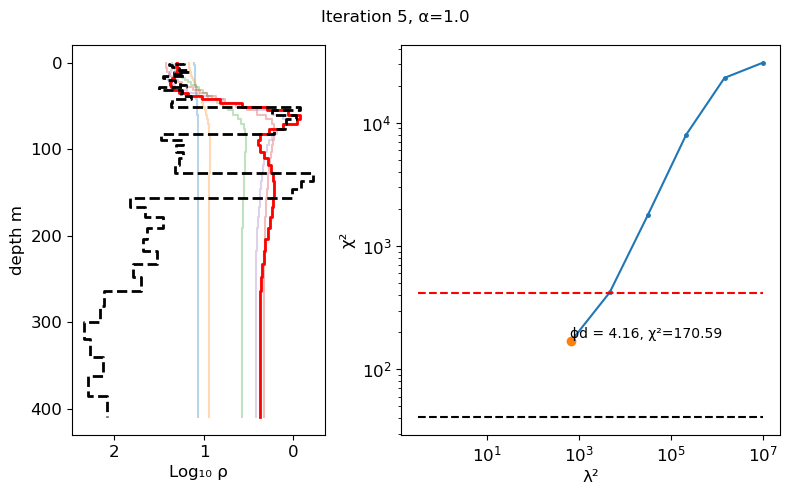

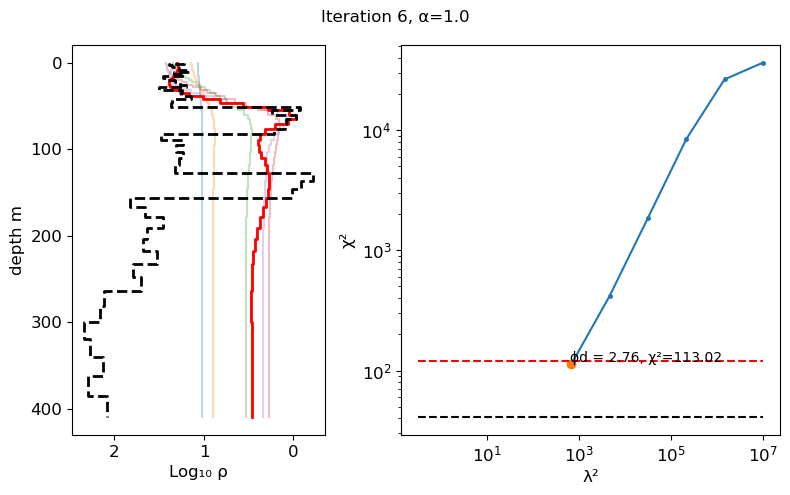

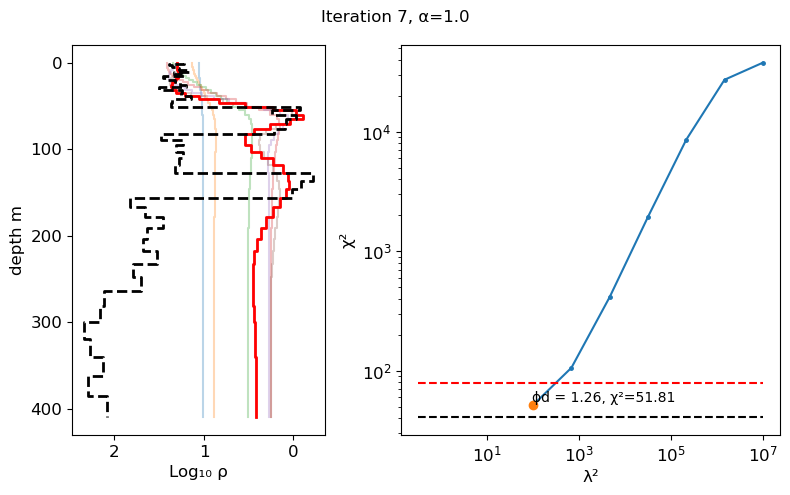

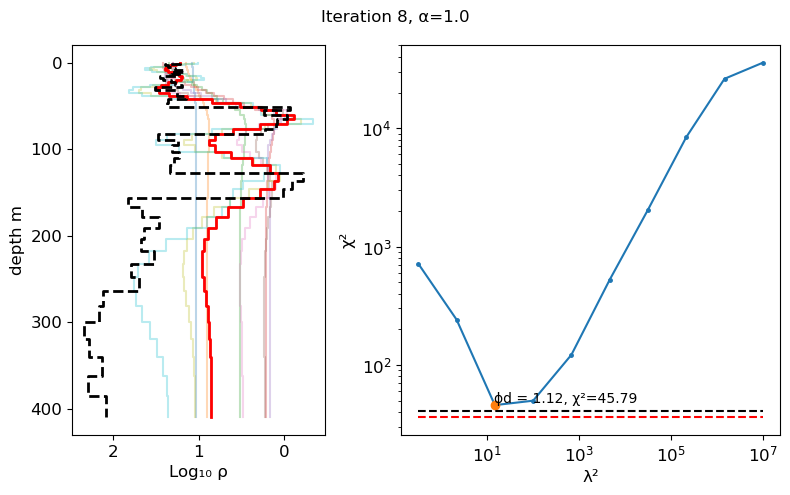

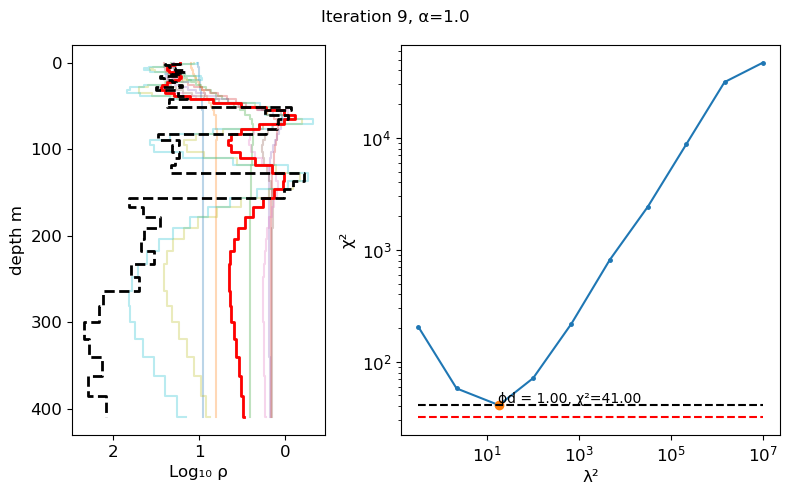

In [19]:
# one plot for each outer, non-linear iteration
using Printf
alpha = 0.3
ndata = length(aem.res)
for (i, mi) in enumerate(m)
    f, s = plt.subplots(1, 2, gridspec_kw=Dict("width_ratios" => [1,1.5]),
        figsize=(8,5))
    for ii in 1:length(χ²[i])
        s[1].step(-mi[ii], aem.z[2:end], alpha=alpha)
    end
    s[1].step(-mi[idx[i]], aem.z[2:end], color="r", linewidth=2)
    s[1].step(log10.(ρ[2:end]), z[2:end], color="k", linewidth=2, linestyle="--")
    s[1].set_ylabel("depth m")
    s[1].set_xlabel("Log₁₀ ρ")
    s[1].invert_yaxis()
    s[1].invert_xaxis()
    hps = hcat(λ²[i]...)'
    sortedλidx = sortperm(hps[:,1])
    sortedαidx = sortperm(hps[:,2])
    s[2].loglog(hps[sortedλidx,1], χ²[i][sortedλidx], ".-", markersize=5)
    s[2].plot(hps[idx[i],1], χ²[i][idx[i]], "o" )
    s[2].text(.95hps[idx[i],1], 1.05χ²[i][idx[i]], "ϕd = $(@sprintf("%.2f", χ²[i][idx[i]]/ndata)), χ²=$(@sprintf("%.2f", χ²[i][idx[i]]))" )
    s[2].plot(10 .^[λ²min, λ²max], [ndata, ndata], "--k")
    if i > 1
        target = knownvalue*χ²[i-1][idx[i-1]]
        s[2].plot(10 .^[λ²min, λ²max], [target, target], "--r")
    end
    s[2].set_ylabel("χ²")
    s[2].set_xlabel("λ²")
    plt.suptitle("Iteration $i, α=$(hps[idx[i],2])")
    transD_GP.nicenup(gcf(), fsize=12)
end

# Plots for best in each iteration

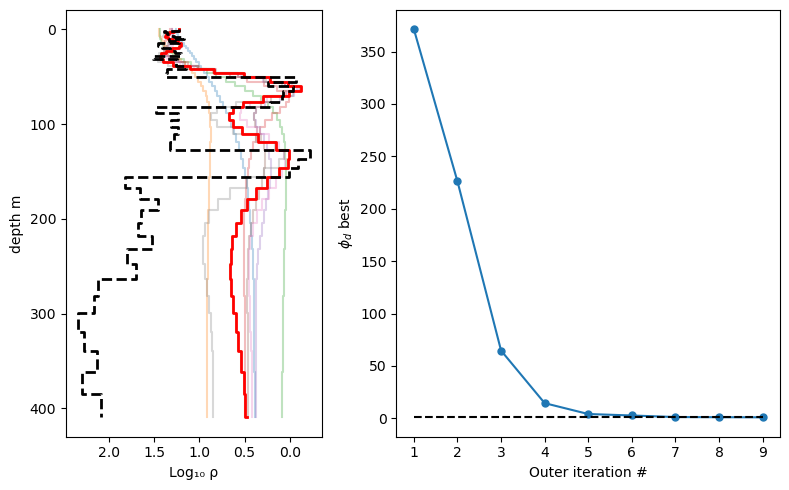

In [20]:
f, s = plt.subplots(1, 2, gridspec_kw=Dict("width_ratios" => [1,1.5]),
        figsize=(8,5))
alpha = 0.3
χ²best = [minimum(x) for x in χ²]
idxlast = length(m)
ndata = length(aem.res)
for (i, mi) in enumerate(m)
    s[1].step(-mi[idx[i]], aem.z[2:end], alpha=alpha)
end
s[1].step(-m[end][idx[end]], aem.z[2:end], color="r", linewidth=2)
s[1].step(log10.(ρ[2:end]), z[2:end], color="k", linewidth=2, linestyle="--")
s[1].invert_yaxis()
s[1].invert_xaxis()
s[1].set_ylabel("depth m")
s[1].set_xlabel("Log₁₀ ρ")
s[2].plot(1:length(m), χ²best/ndata, ".-", ms=10)
s[2].plot([1, idxlast], [1, 1], "--k")
s[2].set_xlabel("Outer iteration #")
s[2].set_ylabel(L"ϕ_d"*" best")
f.tight_layout()

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*